Here we will follow professor's colab in order to create a MLP. Here is the link to the colab:https://colab.research.google.com/drive/1gmm92ZzBF_pB9QcHA91dhRte2saC7pf1. No further explanation is needed. Attention is all you need.


In [126]:
import torch                     # for all things PyTorch
import pandas as pd
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F  # for the activation function
import numpy as np
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [127]:
class FlexibleMLP(nn.Module):
    def __init__(self, layers: list, scale: float = 1.0, bias_scale: float = 0.0, activation=nn.GELU()):
        """
        Initialize a customizable Multi-Layer Perceptron (MLP) with flexible architecture and initialization.

        Args:
            layers (list of int): A list of integers where each value defines the size of each layer.
                                  For example, layers=[10, 64, 32, 1] defines a network with input dimension 10,
                                  two hidden layers with sizes 64 and 32, and output dimension 1.
            scale (float): Scaling factor for weight initialization. Controls the standard deviation of
                           the normal distribution used in initializing weights. Recommended to be 1.0 for LeCun initialization.
            bias_scale (float): Scaling factor for bias initialization. Often set to 0.0 to start with no initial bias.
            activation (nn.Module): Activation function applied after each linear transformation except the last layer.
                                    Defaults to nn.GELU(), but can be any activation like nn.ReLU(), nn.Tanh(), etc.
        """
        # Call the constructor of the parent class (nn.Module) to initialize all internal PyTorch machinery.
        # This is crucial because nn.Module handles a lot of behind-the-scenes logic like:
        # - registering parameters (weights and biases) for automatic optimization
        # - setting up .to(device), .eval(), .train(), etc.
        # - tracking submodules (layers, activations, etc.)
        #
        # If you omit this line, the module will NOT work correctly in PyTorch:
        # things like model.cuda(), model.parameters(), model.state_dict(), etc. will all break.
        #
        # The super() call here:
        # - FlexibleMLP is our class
        # - nn.Module is the parent class
        # - self.__init__() is the method we want to call from the parent
        super(FlexibleMLP, self).__init__()

        # Save arguments as attributes for reuse in reset_parameters
        self.layer_sizes = layers
        self.scale = scale
        self.bias_scale = bias_scale
        self.activation_fn = activation

        # Create containers to hold layers and activations
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        # Build network structure (but not weights yet)
        self._build_layers()

        # Initialize weights and biases
        self.reset_parameters()

    def _build_layers(self):
        """
        Build the linear layers and corresponding activations (except for initialization).
        """
        for i in range(len(self.layer_sizes) - 1):
            # Create a linear layer from layer i to layer i+1
            layer = nn.Linear(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.layers.append(layer)

            # Add an activation function unless it's the final layer
            if i < len(self.layer_sizes) - 2:
                self.activations.append(self.activation_fn)
            else:
                # Final layer doesn't use activation (use Identity to keep list structure consistent)
                self.activations.append(nn.Identity())

    def reset_parameters(self):
        """
        Apply custom initialization to all layers using the given scale and bias_scale.
        """
        for i, layer in enumerate(self.layers):
            # Apply LeCun-style initialization for better gradient behavior
            nn.init.normal_(layer.weight, mean=0.0, std=self.scale * np.sqrt(1 / self.layer_sizes[i]))
            nn.init.normal_(layer.bias, mean=0.0, std=self.bias_scale * np.sqrt(1 / self.layer_sizes[i]))

    def forward(self, x, return_last_hidden=False):
        """
        Perform a forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
            return_last_hidden (bool): If True, returns both the final output and the last hidden layer's output.
                                       Useful for feature extraction, analysis, or interpretability.

        Returns:
            torch.Tensor: Output of the final layer.
            torch.Tensor (optional): Output of the last hidden layer (before final linear layer),
                                     if return_last_hidden is set to True.
        """
        last_hidden = None  # Will store the output of the last hidden layer

        # Apply all but the last layer with activation
        for layer, activation in zip(self.layers[:-1], self.activations[:-1]):
            x = activation(layer(x))  # Apply linear transformation and activation
            last_hidden = x  # Save the last hidden output

        # Final layer (linear transformation only, no activation)
        x = self.layers[-1](x)

        if return_last_hidden:
            return x, last_hidden
        return x


In [128]:
# Example usage:
# Create an MLP with input size of 10, two hidden layers with 64 and 32 neurons,
# and an output size of 5.
layer_sizes = [10, 64, 32, 1] # use this to see parameters: [2, 3, 2, 1]#
model = FlexibleMLP(layer_sizes, scale=2., bias_scale=0.)
print(model.parameters())

num_param = 0

for name, param in model.named_parameters():
  print(param)
  print(param.shape)
  num_param += param.numel()

print(f'Total number of parameters: {num_param}')

<generator object Module.parameters at 0x159451cf0>
Parameter containing:
tensor([[ 6.3686e-01,  8.4078e-01, -1.4175e-02, -2.6850e-02,  5.4663e-01,
         -1.9757e-01,  1.3496e-01,  6.5039e-01,  2.8905e-01, -1.3444e-01],
        [-7.6251e-01,  7.6877e-01, -3.4985e-01,  9.5796e-01, -1.4475e-01,
         -1.6878e-01, -1.0276e+00,  6.1902e-01, -1.3406e-01, -2.8436e-01],
        [-9.3413e-01, -2.6702e-01,  6.8995e-01,  7.3949e-01,  3.3985e-01,
          4.8398e-02,  2.0938e-01,  7.1564e-01, -2.2972e-01, -2.8483e-01],
        [ 1.3444e-01,  1.0243e-01, -8.6104e-01, -1.0965e-01,  6.0615e-01,
          1.7848e-01, -4.2529e-01, -4.2075e-01,  6.3001e-01, -5.2980e-01],
        [-1.3480e-01, -1.4241e+00,  1.6077e-01, -3.2276e-02, -7.9266e-01,
          7.3656e-01, -2.9789e-01,  1.2361e-02,  1.2839e+00, -1.0527e-01],
        [-2.8496e-01, -1.1604e-01, -7.1703e-01, -7.9147e-01, -2.7793e-02,
         -2.9027e-01, -1.1640e-01, -6.3503e-01, -5.9159e-01, -2.2021e-01],
        [-2.5962e-01, -1.3775e-0

In [129]:
def set_seed(seed_value=42):
    """
    Set random seed across NumPy, Python, and PyTorch to ensure reproducibility.

    Args:
        seed_value (int): The seed value to use. Default is 42, a commonly used arbitrary number.

    This function ensures that experiments produce the same results across different runs,
    which is critical for debugging, comparing models, and scientific reproducibility.

    It sets the seed for:
        - NumPy (used for numerical ops like matrix generation)
        - Python's built-in random module (used in random sampling, shuffling, etc.)
        - PyTorch (both CPU and GPU)

    For GPU reproducibility:
        - It manually sets the CUDA seeds (for single and multi-GPU setups)
        - It disables the CUDA backend benchmarking feature to ensure deterministic behavior
          (at the potential cost of performance).
    """

    # Set seed for NumPy (used in data shuffling, batch generation, etc.)
    np.random.seed(seed_value)

    # Set seed for PyTorch operations on CPU
    torch.manual_seed(seed_value)

    # Set seed for Python's built-in random module (e.g., random.shuffle, random.randint)
    random.seed(seed_value)

    # Set seeds for PyTorch operations on GPU
    if torch.cuda.is_available():
        # Set seed for single-GPU
        torch.cuda.manual_seed(seed_value)

        # Set seed for all available GPUs (multi-GPU training)
        torch.cuda.manual_seed_all(seed_value)

        # Ensures that CUDA uses deterministic algorithms
        # This disables non-deterministic optimizations and ensures reproducible behavior
        torch.backends.cudnn.deterministic = True

        # Disables cuDNN auto-tuner which selects the best algorithm for each configuration
        # When disabled, it uses deterministic algorithms, but this might make training slower
        torch.backends.cudnn.benchmark = False

# Set the seed globally so every run starts from the same state
set_seed(42)


In [130]:
def prepare_lagged_mlp_data(df: pd.DataFrame, symbol: str, max_lag: int = 10, test_size: float = 0.8, seed: int = 42):
    """
    Prepare lagged feature matrix and target vector from stock returns,
    and split into PyTorch-ready training and test sets.

    Args:
        df (pd.DataFrame): must contain ['SYMBOL', 'DATE', 'TIME', 'RETURN']
        symbol (str): asset to process
        max_lag (int): number of lagged returns as features
        test_size (float): fraction of data to allocate to test set
        seed (int): random seed for reproducibility

    Returns:
        train_loader, test_loader: PyTorch DataLoader objects
        input_dim: int, number of input features (should be max_lag)
    """
    group = df[df['SYMBOL'] == symbol].sort_values(by=['DATE', 'TIME']).reset_index(drop=True)
    returns = group['RETURN'].values.astype(np.float32)

    if len(returns) < max_lag + 1:
        raise ValueError("Not enough data to build lagged features.")

    # Build lagged features (X) and corresponding target (y)
    X = np.column_stack([returns[i:len(returns)-max_lag+i] for i in range(max_lag)])
    y = returns[max_lag:]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed, shuffle=False
    )
    X_scaler = StandardScaler()
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Wrap in datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, X.shape[1],y_test



In [131]:
# Load data
df = pd.read_parquet('/Users/emanueledurante/Desktop/LGMB/lausanne/epfl/MLfinance/High-Frequency-Trading-with-Deep-Learning/data/high_10m.parquet')

# Pick a random symbol
available_symbols = df['SYMBOL'].unique()
symbol = np.random.choice(available_symbols)
print(f"Selected symbol: {symbol}")

# Prepare data
input_dim = 10
train_loader, test_loader, input_dim, y_test = prepare_lagged_mlp_data(df, symbol, max_lag=input_dim)

# Initialize model
model = FlexibleMLP([input_dim, 64, 32, 64, 32, 64,32, 1], scale=1.0, bias_scale=0.0)

Selected symbol: SBSW


In [132]:
set_seed(42)  # Fixing the seed
criterion = nn.MSELoss()  # For prediction, MSE is the standard objective; but other, custom objective might be better;
# choose loss appropriate for your task
# experiment with learning rates, lr = 0.02, 0.01, 0.001
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # this is one of the most popular gradient descent algorithms
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # experiment with 0.1, 0.2, 0.5. 0.5 is super interesting, achives well OOS!!!

In [133]:
set_seed(42)  # Fixing the seed
import torch.optim as optim
# Proceed with the rest of the setup (loss, optimizer) and training loop as before
# Training loop

# careful, for minibatch 32, 400 is enough!!!
num_epochs = 10000  # You might need more epochs for a deep network
losses = []
cool_loss = []
for epoch in range(num_epochs):
    # now we loop through the mini-batches
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs) # this is f(x;\theta)
        loss = criterion(outputs, targets) # this is \sum_{t\in mini batch} \ell(y_t, f(x_t;\theta))

        # Backward and optimize
        optimizer.zero_grad() # forget the gradients from old steps of Gradient Descent (GD)
        loss.backward() # compute the new gradient, \nabla_\theta L(\theta)
        optimizer.step() # \theta_{k+1}=\theta_k - \eta \nabla_\theta L(\theta_k).
        losses.append(loss.item())

    cool_loss.append(np.mean(losses))
    losses = []
    print(f"Epoch [{epoch+1}/{num_epochs}] Avg train loss: {np.mean(cool_loss):.6f}")


Epoch [1/10000] Avg train loss: 0.908620
Epoch [2/10000] Avg train loss: 0.906962
Epoch [3/10000] Avg train loss: 0.910506
Epoch [4/10000] Avg train loss: 0.912874
Epoch [5/10000] Avg train loss: 0.939536
Epoch [6/10000] Avg train loss: 0.929902
Epoch [7/10000] Avg train loss: 0.924841
Epoch [8/10000] Avg train loss: 0.924289
Epoch [9/10000] Avg train loss: 0.934963
Epoch [10/10000] Avg train loss: 0.927248
Epoch [11/10000] Avg train loss: 0.937773
Epoch [12/10000] Avg train loss: 0.929730
Epoch [13/10000] Avg train loss: 0.923829
Epoch [14/10000] Avg train loss: 0.933103
Epoch [15/10000] Avg train loss: 0.921161
Epoch [16/10000] Avg train loss: 0.914359
Epoch [17/10000] Avg train loss: 0.920925
Epoch [18/10000] Avg train loss: 0.920369
Epoch [19/10000] Avg train loss: 0.917383
Epoch [20/10000] Avg train loss: 0.909801
Epoch [21/10000] Avg train loss: 0.899535
Epoch [22/10000] Avg train loss: 0.886074
Epoch [23/10000] Avg train loss: 0.887189
Epoch [24/10000] Avg train loss: 0.878237
E

In [134]:
len(losses)

0

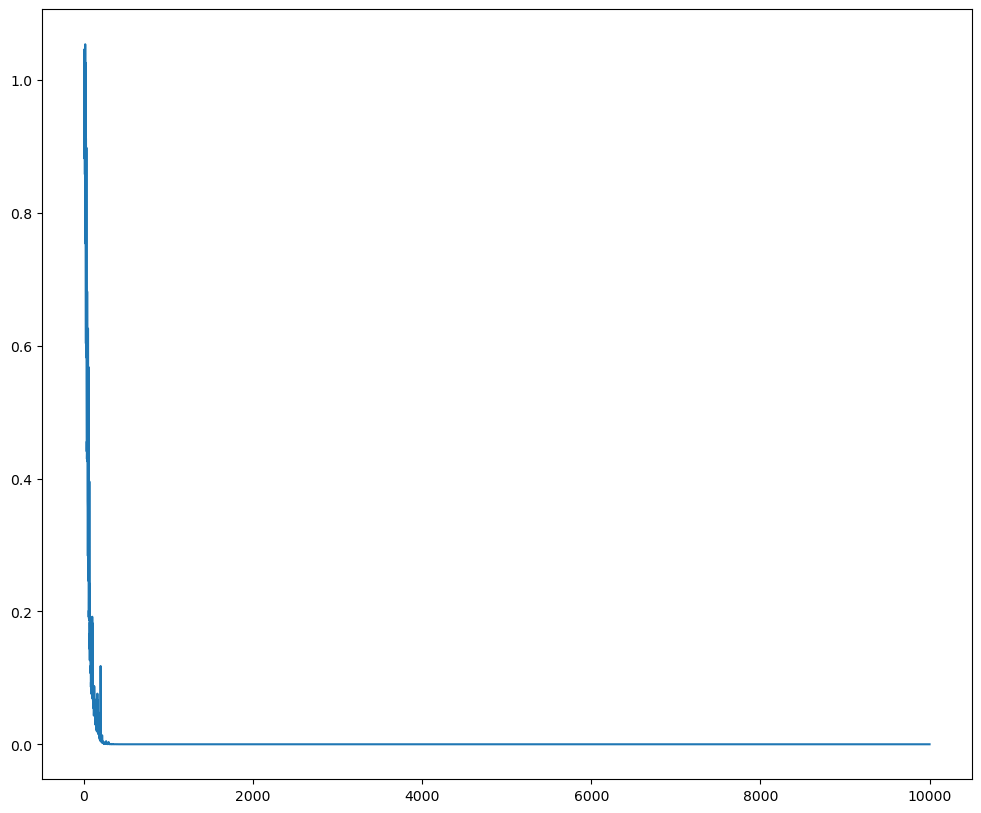

In [135]:
import matplotlib.pyplot as plt
plot_e = np.linspace(1,  num_epochs, num= num_epochs)

plt.figure(figsize=(12, 10))
plt.plot(plot_e, np.array(cool_loss))


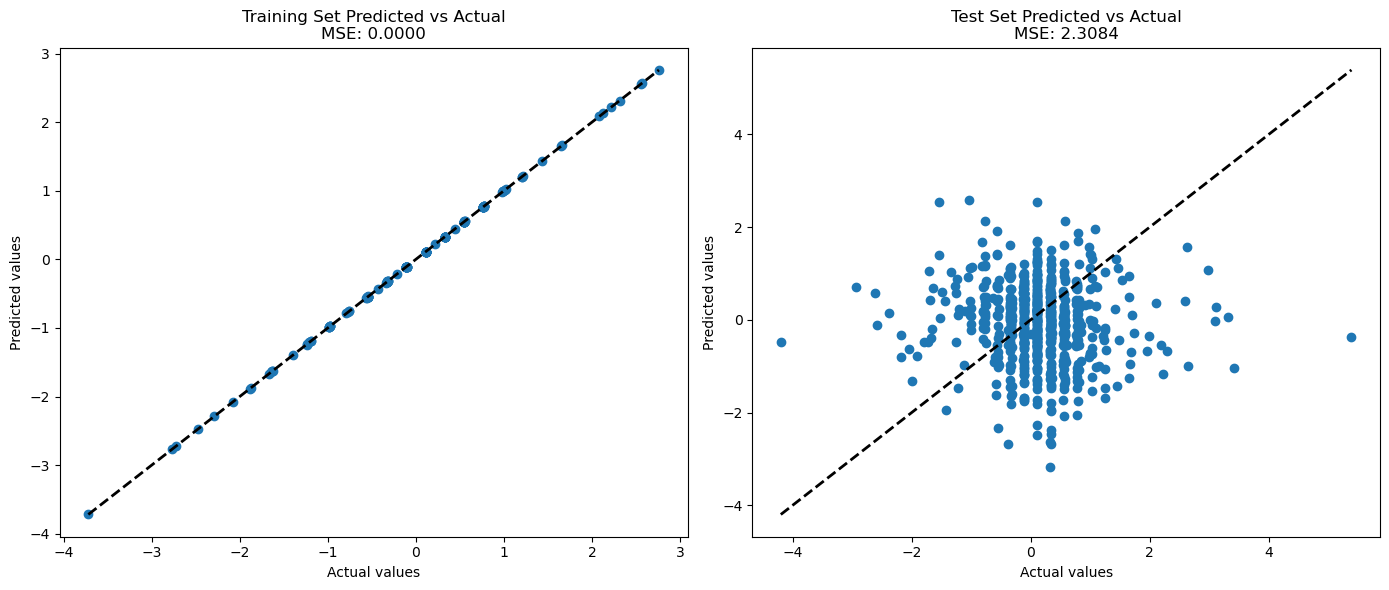

In [136]:
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Function to get predictions
def get_predictions(loader):
    targets = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            targets.extend(labels.numpy())
            predictions.extend(outputs.numpy())

    return np.array(targets).flatten(), np.array(predictions).flatten()

# Get predictions for both training and test sets
train_targets, train_predictions = get_predictions(train_loader)
test_targets, test_predictions = get_predictions(test_loader)
#test_predictions=0.5*test_predictions

# Calculate MSE for both training and test sets
train_mse = np.mean((train_targets - train_predictions) ** 2) / np.mean((train_targets) ** 2)
test_mse = np.mean((test_targets - test_predictions) ** 2) / np.mean((test_targets) ** 2)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Training set subplot
axs[0].scatter(train_targets, train_predictions)
axs[0].plot([train_targets.min(), train_targets.max()], [train_targets.min(), train_targets.max()], 'k--', lw=2)  # Diagonal line
axs[0].set_xlabel('Actual values')
axs[0].set_ylabel('Predicted values')
axs[0].set_title(f'Training Set Predicted vs Actual\nMSE: {train_mse:.4f}')

# Test set subplot
axs[1].scatter(test_targets, test_predictions)
axs[1].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'k--', lw=2)  # Diagonal line
axs[1].set_xlabel('Actual values')
axs[1].set_ylabel('Predicted values')
axs[1].set_title(f'Test Set Predicted vs Actual\nMSE: {test_mse:.4f}')

plt.tight_layout()
plt.show()


Test sign prediction accuracy: 44.93%
99% CI under null: [39.92%, 49.94%] — Significant? YES


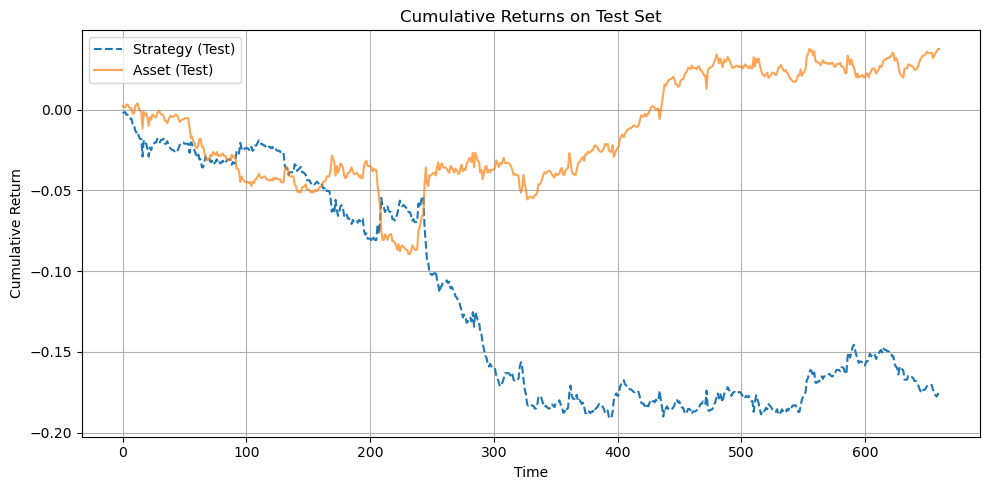

In [137]:
from scipy.stats import norm

# === 1. SIGN PREDICTION ACCURACY (TEST ONLY) ===
def sign_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred))

test_sign_acc = sign_accuracy(test_targets, test_predictions)

# === 1.1. Confidence interval around 0.5 (coin toss null hypothesis) ===
n_test = len(test_targets)
p_hat = test_sign_acc
p_0 = 0.5
z = norm.ppf(1 - 0.01 / 2)  # two-tailed 99% → z ≈ 2.576
se = np.sqrt(p_0 * (1 - p_0) / n_test)
ci_low = p_hat - z * se
ci_high = p_hat + z * se
significant = "YES" if ci_low > 0.5 or ci_high < 0.5 else "NO"

print(f"Test sign prediction accuracy: {test_sign_acc:.2%}")
print(f"99% CI under null: [{ci_low:.2%}, {ci_high:.2%}] — Significant? {significant}")

# === 2. STRATEGY RETURNS (TEST ONLY) ===
test_strategy_returns = np.sign(test_predictions) * y_test

# === 3. PLOT CUMULATIVE RETURNS (TEST ONLY) ===
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(np.cumsum(test_strategy_returns), label='Strategy (Test)', linestyle='--')
ax.plot(np.cumsum(y_test), label='Asset (Test)', alpha=0.7)

ax.set_title('Cumulative Returns on Test Set')
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

